In [2]:
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pickle
from sklearn.cluster import KMeans
import scprep

In [3]:
adata = sc.read_h5ad('../data/rna_figure_ready.h5ad')
res_dir = '../results_final_Jan15/'

In [4]:
# from https://www.gsea-msigdb.org/gsea/msigdb/human/geneset/HALLMARK_APOPTOSIS.html
apoptosis_markers = ["ADD1","AIFM3","ANKH","ANXA1","APP","ATF3","AVPR1A","BAX","BCAP31","BCL10","BCL2L1","BCL2L10","BCL2L11","BCL2L2","BGN","BID","BIK","BIRC3","BMF","BMP2","BNIP3L","BRCA1","BTG2","BTG3","CASP1","CASP2","CASP3","CASP4","CASP6","CASP7","CASP8","CASP9","CAV1","CCNA1","CCND1","CCND2","CD14","CD2","CD38","CD44","CD69","CDC25B","CDK2","CDKN1A","CDKN1B","CFLAR","CLU","CREBBP","CTH","CTNNB1","CYLD","DAP","DAP3","DCN","DDIT3","DFFA","DIABLO","DNAJA1","DNAJC3","DNM1L","DPYD","EBP","EGR3","EMP1","ENO2","ERBB2","ERBB3","EREG","ETF1","F2","F2R","FAS","FASLG","FDXR","FEZ1","GADD45A","GADD45B","GCH1","GNA15","GPX1","GPX3","GPX4","GSN","GSR","GSTM1","GUCY2D","H1-0","HGF","HMGB2","HMOX1","HSPB1","IER3","IFITM3","IFNB1","IFNGR1","IGF2R","IGFBP6","IL18","IL1A","IL1B","IL6","IRF1","ISG20","JUN","KRT18","LEF1","LGALS3","LMNA","LUM","MADD","MCL1","MGMT","MMP2","NEDD9","NEFH","PAK1","PDCD4","PDGFRB","PEA15","PLAT","PLCB2","PLPPR4","PMAIP1","PPP2R5B","PPP3R1","PPT1","PRF1","PSEN1","PSEN2","PTK2","RARA","RELA","RETSAT","RHOB","RHOT2","RNASEL","ROCK1","SAT1","SATB1","SC5D","SLC20A1","SMAD7","SOD1","SOD2","SPTAN1","SQSTM1","TAP1","TGFB2","TGFBR3","TIMP1","TIMP2","TIMP3","TNF","TNFRSF12A","TNFSF10","TOP2A","TSPO","TXNIP","VDAC2","WEE1","XIAP"]
apoptosis_markers = [g for g in apoptosis_markers if g in adata.var_names]
len(apoptosis_markers)

156

In [5]:
sc.tl.score_genes(adata, gene_list=apoptosis_markers, score_name='apoptosis_score')

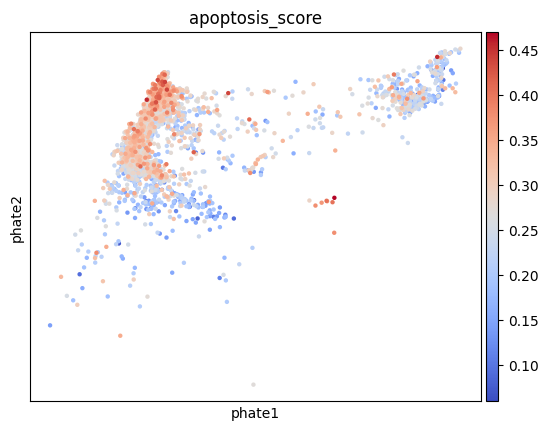

In [6]:
sc.external.pl.phate(adata[adata.obs['day'] == 30], color='apoptosis_score', cmap='coolwarm')


In [7]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')
mt_markers = adata.var_names[adata.var['mt'] == True]
len(mt_markers)

13

In [8]:
sc.tl.score_genes(adata, gene_list=mt_markers, score_name='mt_score')

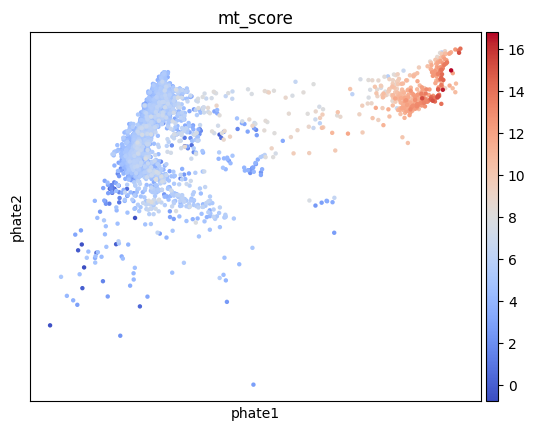

In [9]:
sc.external.pl.phate(adata[adata.obs['day'] == 30], color='mt_score', cmap='coolwarm')

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/mioflow/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


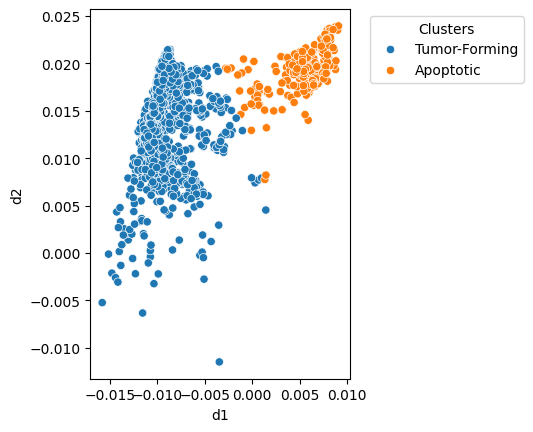

In [10]:
# with open('../results_final_Dec22/scaler.pkl', 'rb') as f:
    # scaler = pickle.load(f)
# X_phate = scaler.transform(adata.obsm['X_phate'])
# cluster "starting" points and annotate trajectories
np.random.seed(32)
# t0_df = df[df['samples'] == 3].copy()
subset = adata[adata.obs['day'] == adata.obs['day'].max()].obsm['X_phate']
t0_df = pd.DataFrame(subset, columns=['d1', 'd2'])

kmeans = KMeans(n_clusters=2)
t0_df['cluster'] = kmeans.fit_predict(t0_df[['d1', 'd2']])
t0_df['cluster'] = t0_df['cluster'].map({0: 'Tumor-Forming', 1: 'Apoptotic'})

# subset = scaler.transform(subset)
# t0_df[['d1', 'd2']] = subset
# Create scatter plot using seaborn
scatter = sns.scatterplot(data=t0_df, x='d1', y='d2', hue='cluster', palette='tab10')

# Add legend
plt.legend(title="Clusters", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.gca().set_aspect('equal')


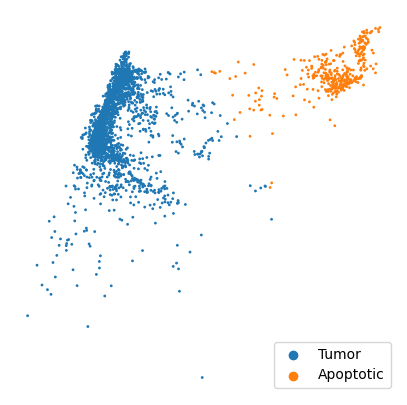

In [33]:
plt.figure(figsize=(5, 5))
scatter = plt.scatter(t0_df['d1'], t0_df['d2'], c=['tab:blue' if x=='Tumor-Forming' else 'tab:orange' for x in t0_df['cluster']], s=1)
# plt.gca().set_aspect('equal')
# Create legend handles manually for both classes
legend_elements = [plt.scatter([], [], c='tab:blue', label='Tumor'),
                  plt.scatter([], [], c='tab:orange', label='Apoptotic')]
plt.legend(handles=legend_elements, loc='lower right')
plt.box(False)
plt.tick_params(left=False, bottom=False)
plt.xticks([])
plt.yticks([])
plt.savefig(f'{res_dir}/subpop_color.png', bbox_inches='tight', dpi=300)